## Neural Network Design Choices Using Fashion-MNIST

**Portfolio Piece 1** — Extending Lab 2 (Neural Network Exploration)


---
## 1. Setup & Data Exploration

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import sys, os

# Add src/ to path so we can import our utilities
sys.path.append(os.path.join(os.pardir, 'src'))
from utils import (
    train_model, plot_training_curves, plot_confusion_matrix,
    extract_features, plot_tsne, compare_experiments, count_parameters
)

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

# Device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [2]:
# Fashion-MNIST class names
CLASS_NAMES = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# Standard normalization for Fashion-MNIST (mean=0.2860, std=0.3530)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))
])

# Load datasets
train_dataset = datasets.FashionMNIST(root='../data', train=True, download=True, transform=transform)
test_dataset  = datasets.FashionMNIST(root='../data', train=False, download=True, transform=transform)

# DataLoaders
BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=256, shuffle=False)

print(f"Training samples: {len(train_dataset):,}")
print(f"Test samples:     {len(test_dataset):,}")
print(f"Image shape:      {train_dataset[0][0].shape}")
print(f"Classes:          {len(CLASS_NAMES)}")

100%|██████████| 26.4M/26.4M [00:57<00:00, 463kB/s] 
100%|██████████| 29.5k/29.5k [00:00<00:00, 231kB/s]
100%|██████████| 4.42M/4.42M [00:03<00:00, 1.27MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.62MB/s]

Training samples: 60,000
Test samples:     10,000
Image shape:      torch.Size([1, 28, 28])
Classes:          10


### 1.1 Visualizing the Dataset

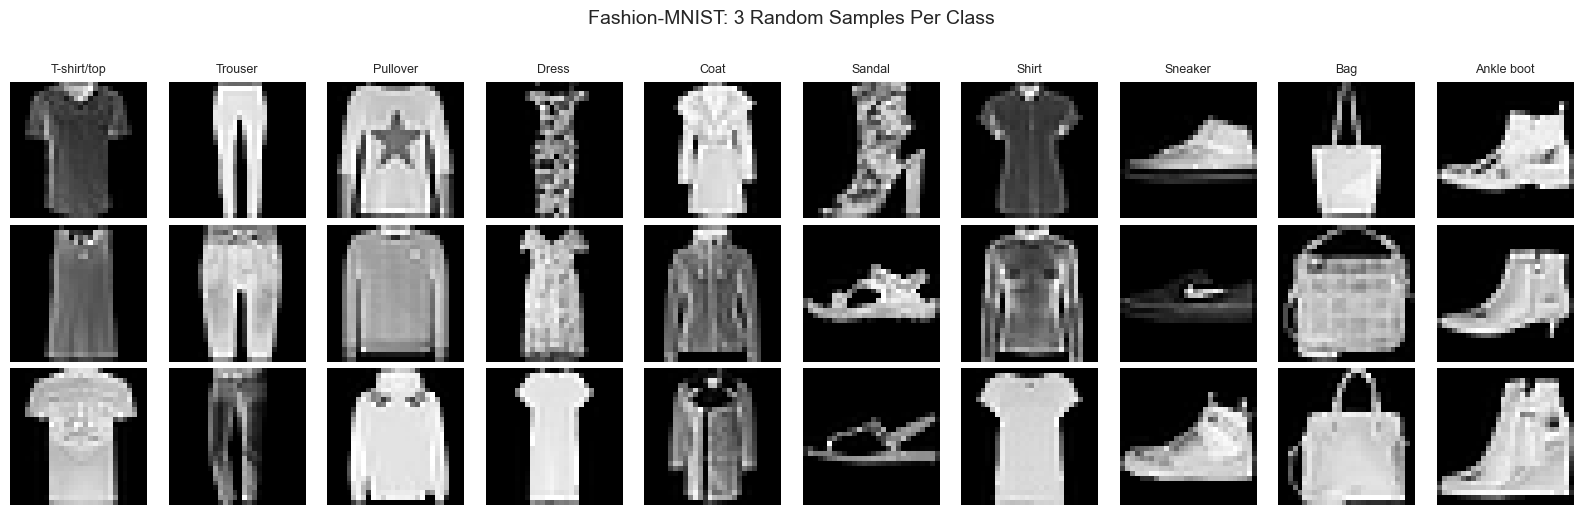

In [3]:
# Show 3 examples per class
fig, axes = plt.subplots(3, 10, figsize=(16, 5))
fig.suptitle('Fashion-MNIST: 3 Random Samples Per Class', fontsize=14, y=1.02)

for class_idx in range(10):
    # Find indices for this class
    class_indices = [i for i, (_, label) in enumerate(train_dataset) if label == class_idx]
    samples = np.random.choice(class_indices, 3, replace=False)
    
    for row, idx in enumerate(samples):
        img, _ = train_dataset[idx]
        axes[row, class_idx].imshow(img.squeeze(), cmap='gray')
        axes[row, class_idx].axis('off')
        if row == 0:
            axes[row, class_idx].set_title(CLASS_NAMES[class_idx], fontsize=9)

plt.tight_layout()
plt.savefig('../outputs/dataset_samples.png', dpi=150, bbox_inches='tight')
plt.show()

/var/folders/7h/68jc6ngd1yg55vr00gflfwym0000gn/T/ipykernel_69415/1626841091.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(CLASS_NAMES, rotation=30, ha='right')


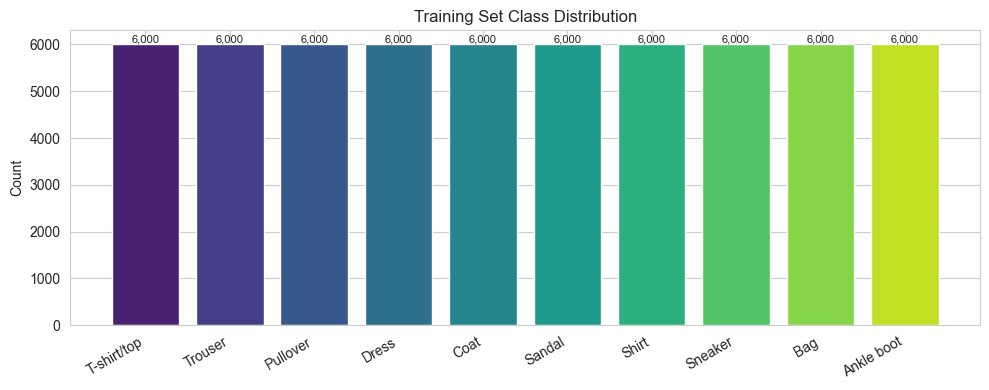


The dataset is perfectly balanced and there 6,000 samples per class.
We can use accuracy as an evaluation metric because there is no class imbalance.


In [5]:
# Class distribution
train_labels = [label for _, label in train_dataset]
label_counts = Counter(train_labels)

fig, ax = plt.subplots(figsize=(10, 4))
bars = ax.bar(CLASS_NAMES, [label_counts[i] for i in range(10)], color=sns.color_palette('viridis', 10))
ax.set_ylabel('Count')
ax.set_title('Training Set Class Distribution')
ax.set_xticklabels(CLASS_NAMES, rotation=30, ha='right')
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
            f'{int(bar.get_height()):,}', ha='center', fontsize=8)
plt.tight_layout()
plt.show()

print("\nThe dataset is perfectly balanced and there 6,000 samples per class.")
print("We can use accuracy as an evaluation metric because there is no class imbalance.")

### 1.2 Pixel Intensity Analysis

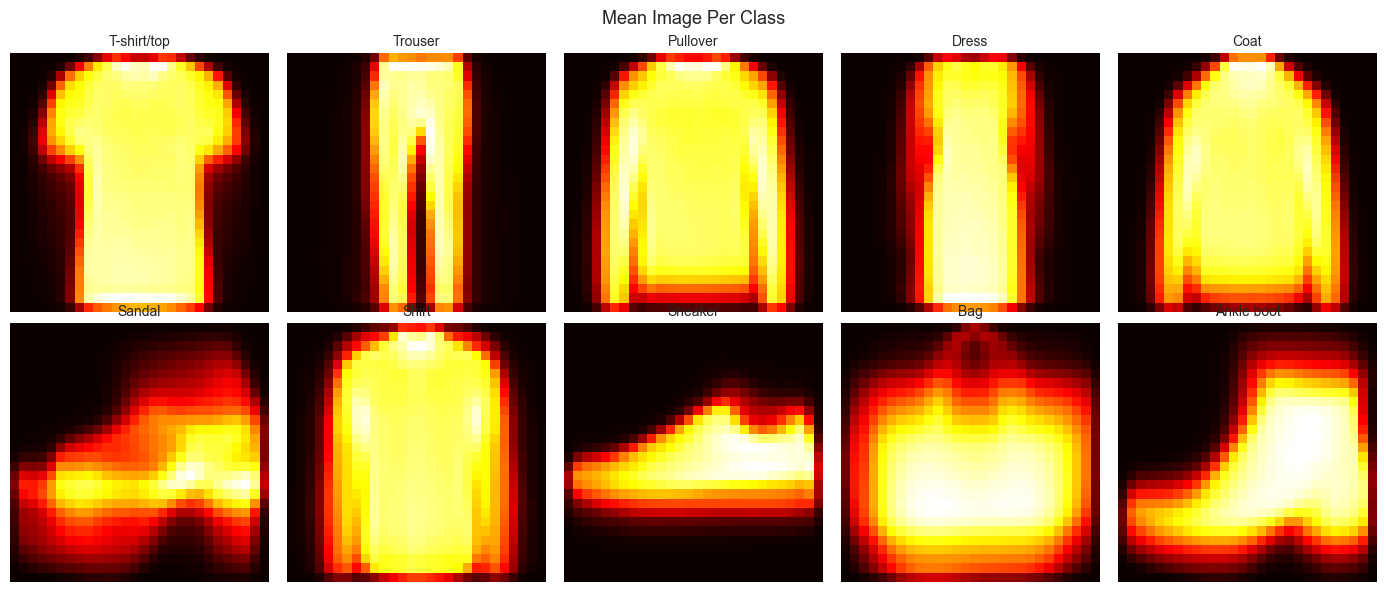

T-shirt, Pullover, Coat, and Shirt have very similar mean images.
Thus the network must learn very subtle features to be able to distinguish them.


In [7]:
# Compute mean image per class (using raw pixels, not normalized)
raw_transform = transforms.ToTensor()
raw_dataset = datasets.FashionMNIST(root='../data', train=True, download=False, transform=raw_transform)

mean_images = {}
for class_idx in range(10):
    class_imgs = torch.stack([raw_dataset[i][0] for i in range(len(raw_dataset)) if raw_dataset[i][1] == class_idx])
    mean_images[class_idx] = class_imgs.mean(dim=0).squeeze()

fig, axes = plt.subplots(2, 5, figsize=(14, 6))
fig.suptitle('Mean Image Per Class', fontsize=13)

for idx, ax in enumerate(axes.flat):
    ax.imshow(mean_images[idx], cmap='hot')
    ax.set_title(CLASS_NAMES[idx], fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.savefig('../outputs/mean_images.png', dpi=150, bbox_inches='tight')
plt.show()

print("T-shirt, Pullover, Coat, and Shirt have very similar mean images.")
print("Thus the network must learn very subtle features to be able to distinguish them.")

---
## 2. Baseline Model

Starting with a simple 2-layer MLP as a baseline model

In [8]:
class BaselineMLP(nn.Module):
    """Simple 2-layer MLP. Mirrors what we built in Lab 2."""
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.net = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
    
    def forward(self, x):
        return self.net(self.flatten(x))

# Train baseline
EPOCHS = 30
baseline_model = BaselineMLP().to(device)
optimizer = optim.Adam(baseline_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

total_params, _ = count_parameters(baseline_model)
print(f"Baseline MLP: {total_params:,} parameters")
print(f"Training for {EPOCHS} epochs...\n")

baseline_history = train_model(
    baseline_model, train_loader, test_loader, optimizer, criterion,
    device, epochs=EPOCHS
)

Baseline MLP: 109,386 parameters
Training for 30 epochs...

  Epoch   1/30 | Train Loss: 0.5076  Acc: 81.9% | Val Loss: 0.4366  Acc: 84.2%
  Epoch   5/30 | Train Loss: 0.2843  Acc: 89.3% | Val Loss: 0.3443  Acc: 87.4%
  Epoch  10/30 | Train Loss: 0.2219  Acc: 91.7% | Val Loss: 0.3368  Acc: 88.5%
  Epoch  15/30 | Train Loss: 0.1816  Acc: 93.1% | Val Loss: 0.3502  Acc: 88.6%
  Epoch  20/30 | Train Loss: 0.1501  Acc: 94.3% | Val Loss: 0.3680  Acc: 88.8%
  Epoch  25/30 | Train Loss: 0.1244  Acc: 95.3% | Val Loss: 0.4362  Acc: 88.7%
  Epoch  30/30 | Train Loss: 0.1098  Acc: 95.9% | Val Loss: 0.4632  Acc: 88.6%
  ✓ Best val acc: 88.99% at epoch 12 (215.6s)


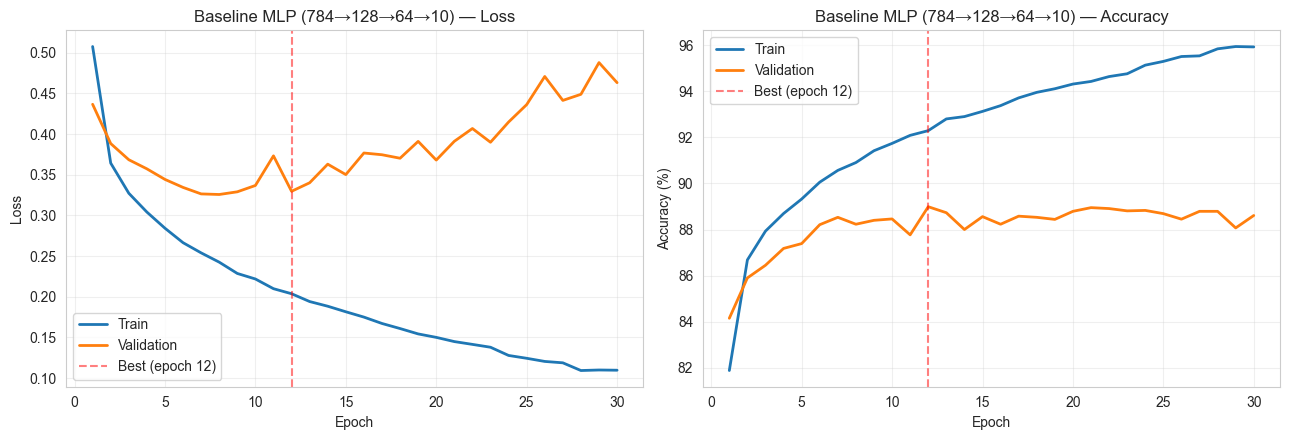

In [9]:
plot_training_curves(baseline_history, title='Baseline MLP (784→128→64→10)')

There is a gap between train and validation accuracy. the model starts overfitting early, which suggests we must employ regularization later

---
## 3. Architecture Experiments

### 3.1 Experiment: Network Depth

In [12]:
class FlexibleMLP(nn.Module):
    """
    MLP with configurable depth, width, and activation.
    All hidden layers use the same width for controlled experiments.
    """
    def __init__(self, input_dim=784, hidden_dim=128, output_dim=10,
                 num_hidden=2, activation='relu', dropout=0.0, use_batchnorm=False):
        super().__init__()
        self.flatten = nn.Flatten()
        
        # Map activation names to functions
        act_fn = {
            'relu': nn.ReLU(),
            'tanh': nn.Tanh(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'gelu': nn.GELU(),
            'sigmoid': nn.Sigmoid()
        }[activation]
        
        layers = []
        # First hidden layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        if use_batchnorm:
            layers.append(nn.BatchNorm1d(hidden_dim))
        layers.append(act_fn)
        if dropout > 0:
            layers.append(nn.Dropout(dropout))
        
        # Additional hidden layers
        for _ in range(num_hidden - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(act_fn)
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
        
        # Output
        layers.append(nn.Linear(hidden_dim, output_dim))
        
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(self.flatten(x))

In [16]:
# Depth experiment: 1, 2, 3, 5hidden layers (all width=128)
#testing multiple hidden layers with 128 width and relu activation, no dropout or batchnorm
depth_results = {}
depth_configs = [1, 2, 3, 5]

for n_layers in depth_configs:
    name = f"{n_layers} hidden layer{'s' if n_layers > 1 else ''}"
    print(f"Training: {name}")
    
    model = FlexibleMLP(num_hidden=n_layers, hidden_dim=128).to(device)
    total, _ = count_parameters(model)
    print(f"  Parameters: {total:,}")
    
    opt = optim.Adam(model.parameters(), lr=1e-3)
    history = train_model(model, train_loader, test_loader, opt, criterion, device, epochs=EPOCHS)
    depth_results[name] = history

Training: 1 hidden layer
  Parameters: 101,770
  Epoch   1/30 | Train Loss: 0.4896  Acc: 82.4% | Val Loss: 0.4121  Acc: 85.2%
  Epoch   5/30 | Train Loss: 0.2824  Acc: 89.6% | Val Loss: 0.3629  Acc: 86.5%
  Epoch  10/30 | Train Loss: 0.2234  Acc: 91.7% | Val Loss: 0.3399  Acc: 88.1%
  Epoch  15/30 | Train Loss: 0.1838  Acc: 93.2% | Val Loss: 0.3449  Acc: 88.6%
  Epoch  20/30 | Train Loss: 0.1558  Acc: 94.2% | Val Loss: 0.3744  Acc: 88.6%
  Epoch  25/30 | Train Loss: 0.1347  Acc: 95.0% | Val Loss: 0.3906  Acc: 88.7%
  Epoch  30/30 | Train Loss: 0.1168  Acc: 95.7% | Val Loss: 0.4285  Acc: 88.6%
  ✓ Best val acc: 88.96% at epoch 24 (370.2s)
Training: 2 hidden layers
  Parameters: 118,282
  Epoch   1/30 | Train Loss: 0.5030  Acc: 82.0% | Val Loss: 0.4143  Acc: 85.1%
  Epoch   5/30 | Train Loss: 0.2765  Acc: 89.6% | Val Loss: 0.3571  Acc: 87.2%
  Epoch  10/30 | Train Loss: 0.2132  Acc: 91.9% | Val Loss: 0.3430  Acc: 88.6%
  Epoch  15/30 | Train Loss: 0.1700  Acc: 93.5% | Val Loss: 0.3628  A

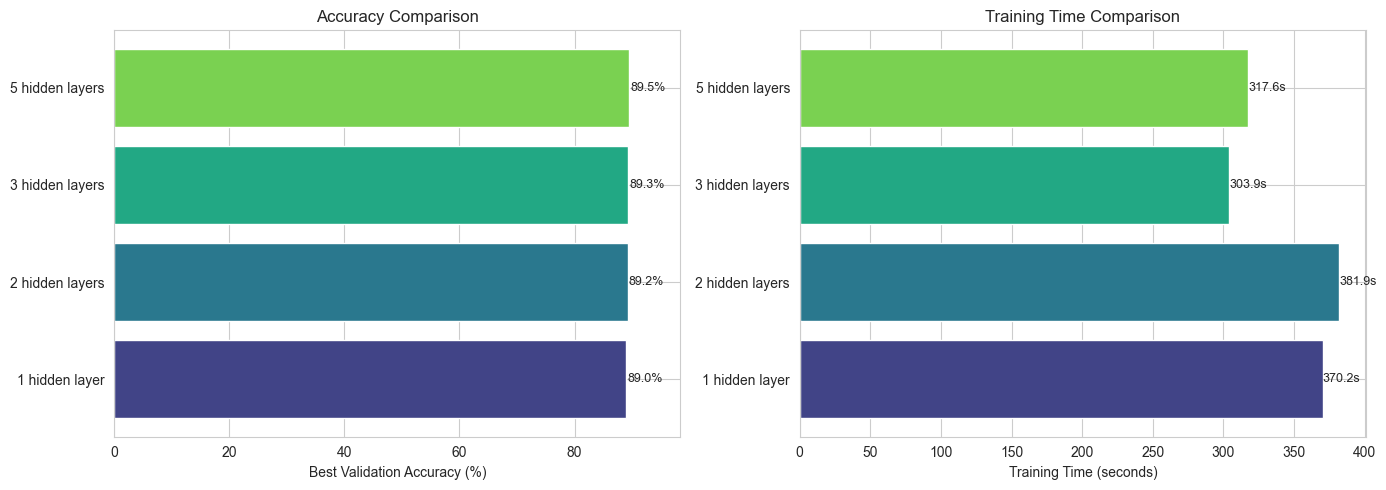

<Figure size 640x480 with 0 Axes>

In [17]:
compare_experiments(depth_results)
plt.savefig('../outputs/depth_comparison.png', dpi=150, bbox_inches='tight')

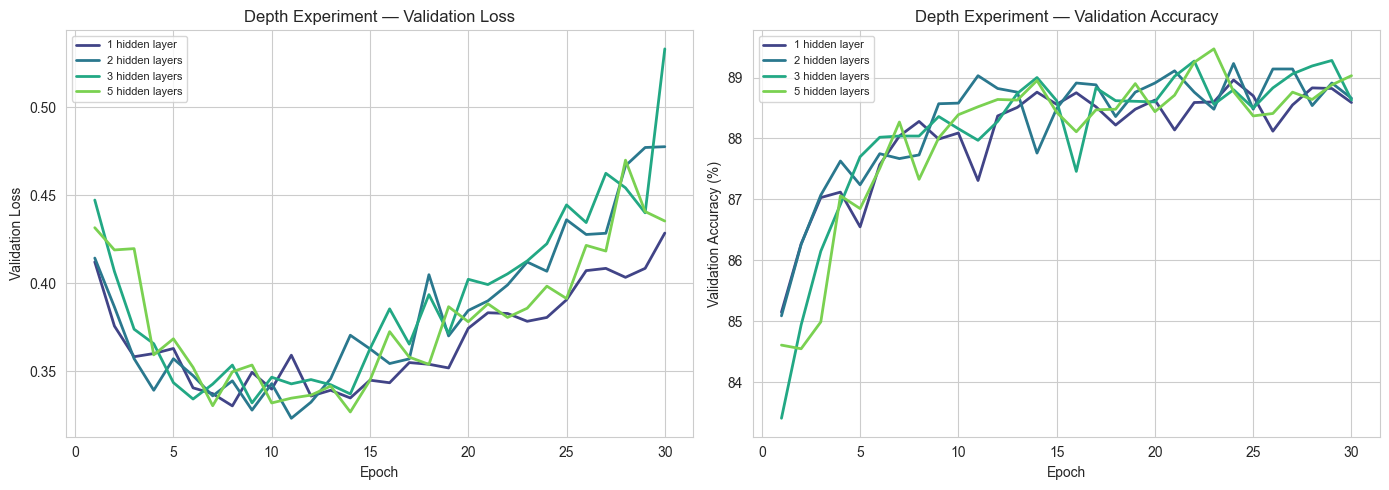

In [18]:
# Overlay all depth loss curves for direct comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
colors = sns.color_palette('viridis', len(depth_results))

for (name, hist), color in zip(depth_results.items(), colors):
    epochs = range(1, len(hist['val_loss']) + 1)
    ax1.plot(epochs, hist['val_loss'], label=name, color=color, linewidth=2)
    ax2.plot(epochs, hist['val_acc'], label=name, color=color, linewidth=2)

ax1.set_xlabel('Epoch'); ax1.set_ylabel('Validation Loss')
ax1.set_title('Depth Experiment — Validation Loss'); ax1.legend(fontsize=8)
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Validation Accuracy (%)')
ax2.set_title('Depth Experiment — Validation Accuracy'); ax2.legend(fontsize=8)
plt.tight_layout()
plt.savefig('../outputs/depth_curves.png', dpi=150, bbox_inches='tight')
plt.show()

**Analysis — Depth:**

Adding depth yields diminishing returns here. We see the gap from 1 to 5 hidden layers is only 0.5% (89.0% → 89.5%), meaning the task doesn't demand deep hierarchical features from a width-128 MLP. Looking at the validation loss: all configurations bottom out around epoch 8–12 then climb sharply, showing every model overfits at roughly the same rate regardless of depth.

### 3.2 Experiment: Network Width


We fix depth at 2 hidden layers and vary width. This will tests the model's capacity which is its ability to represent complex decision boundaries.

In [19]:
width_results = {}
width_configs = [64, 128, 256]

for width in width_configs:
    name = f"Width {width}"
    print(f"Training: {name}")
    
    model = FlexibleMLP(num_hidden=2, hidden_dim=width).to(device)
    total, _ = count_parameters(model)
    print(f"  Parameters: {total:,}")
    
    opt = optim.Adam(model.parameters(), lr=1e-3)
    history = train_model(model, train_loader, test_loader, opt, criterion, device, epochs=EPOCHS)
    width_results[name] = history

Training: Width 64
  Parameters: 55,050
  Epoch   1/30 | Train Loss: 0.5487  Acc: 80.4% | Val Loss: 0.4508  Acc: 83.5%
  Epoch   5/30 | Train Loss: 0.3003  Acc: 88.9% | Val Loss: 0.3573  Acc: 87.1%
  Epoch  10/30 | Train Loss: 0.2446  Acc: 90.8% | Val Loss: 0.3416  Acc: 87.3%
  Epoch  15/30 | Train Loss: 0.2053  Acc: 92.3% | Val Loss: 0.3436  Acc: 88.4%
  Epoch  20/30 | Train Loss: 0.1787  Acc: 93.2% | Val Loss: 0.3555  Acc: 88.6%
  Epoch  25/30 | Train Loss: 0.1587  Acc: 94.0% | Val Loss: 0.3766  Acc: 88.4%
  Epoch  30/30 | Train Loss: 0.1414  Acc: 94.7% | Val Loss: 0.4009  Acc: 88.2%
  ✓ Best val acc: 88.81% at epoch 14 (266.1s)
Training: Width 128
  Parameters: 118,282
  Epoch   1/30 | Train Loss: 0.5064  Acc: 81.8% | Val Loss: 0.4247  Acc: 84.3%
  Epoch   5/30 | Train Loss: 0.2797  Acc: 89.6% | Val Loss: 0.3433  Acc: 87.5%
  Epoch  10/30 | Train Loss: 0.2163  Acc: 91.8% | Val Loss: 0.3468  Acc: 88.1%
  Epoch  15/30 | Train Loss: 0.1747  Acc: 93.5% | Val Loss: 0.3929  Acc: 88.1%
  E

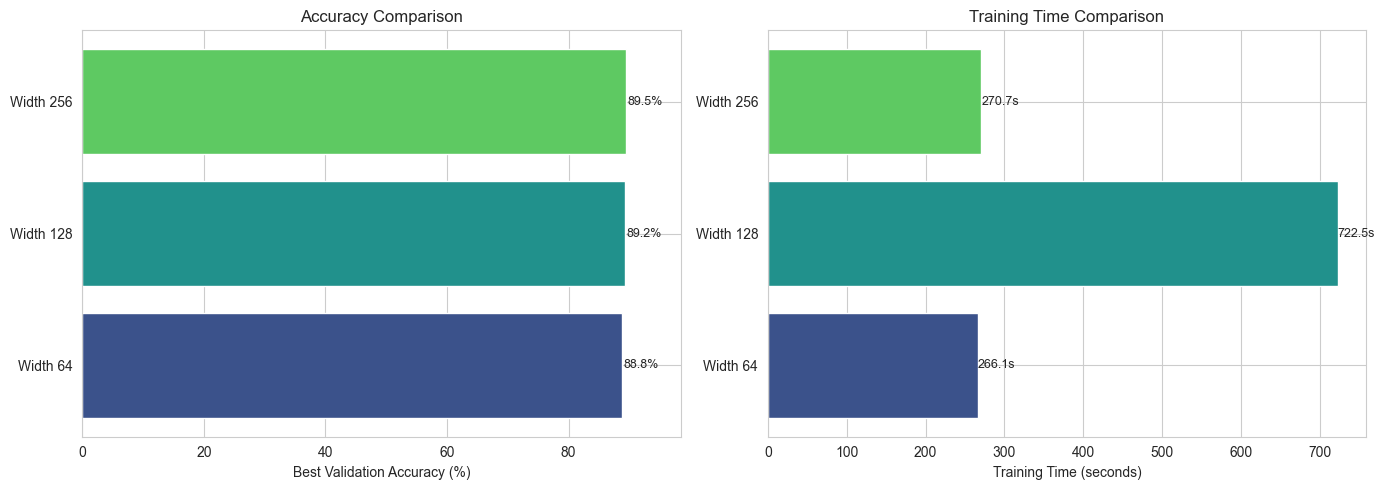

<Figure size 640x480 with 0 Axes>

In [20]:
compare_experiments(width_results)
plt.savefig('../outputs/width_comparison.png', dpi=150, bbox_inches='tight')

**Analysis — Width:**

Widening the network from 64 to 256 neurons yields only a 0.7% gain (88.8% -> 89.5%), showing that even modest capacity is sufficient for Fashion-MNIST and the returns from additional parameters diminish quickly. 

### 3.3 Experiment: Activation Functions

Testing four activations with identical architectures (2 layers, width 128)

In [21]:
activation_results = {}
activations = ['relu', 'leaky_relu', 'gelu', 'sigmoid']

for act in activations:
    name = act.upper() if act != 'leaky_relu' else 'LeakyReLU'
    if act == 'gelu': name = 'GELU'
    print(f"Training: {name}")
    
    model = FlexibleMLP(num_hidden=2, hidden_dim=128, activation=act).to(device)
    opt = optim.Adam(model.parameters(), lr=1e-3)
    history = train_model(model, train_loader, test_loader, opt, criterion, device, epochs=20)
    activation_results[name] = history

Training: RELU
  Epoch   1/20 | Train Loss: 0.5044  Acc: 81.8% | Val Loss: 0.4074  Acc: 85.4%
  Epoch   5/20 | Train Loss: 0.2767  Acc: 89.7% | Val Loss: 0.3503  Acc: 87.5%
  Epoch  10/20 | Train Loss: 0.2137  Acc: 91.9% | Val Loss: 0.3271  Acc: 88.9%
  Epoch  15/20 | Train Loss: 0.1723  Acc: 93.4% | Val Loss: 0.3590  Acc: 88.9%
  Epoch  20/20 | Train Loss: 0.1409  Acc: 94.6% | Val Loss: 0.3986  Acc: 89.2%
  ✓ Best val acc: 89.31% at epoch 18 (188.5s)
Training: LeakyReLU
  Epoch   1/20 | Train Loss: 0.5052  Acc: 81.8% | Val Loss: 0.4318  Acc: 84.4%
  Epoch   5/20 | Train Loss: 0.2826  Acc: 89.5% | Val Loss: 0.3452  Acc: 87.4%
  Epoch  10/20 | Train Loss: 0.2201  Acc: 91.7% | Val Loss: 0.3361  Acc: 88.1%
  Epoch  15/20 | Train Loss: 0.1784  Acc: 93.3% | Val Loss: 0.3524  Acc: 88.7%
  Epoch  20/20 | Train Loss: 0.1485  Acc: 94.3% | Val Loss: 0.3809  Acc: 89.0%
  ✓ Best val acc: 89.53% at epoch 18 (176.7s)
Training: GELU
  Epoch   1/20 | Train Loss: 0.4934  Acc: 82.3% | Val Loss: 0.4123  

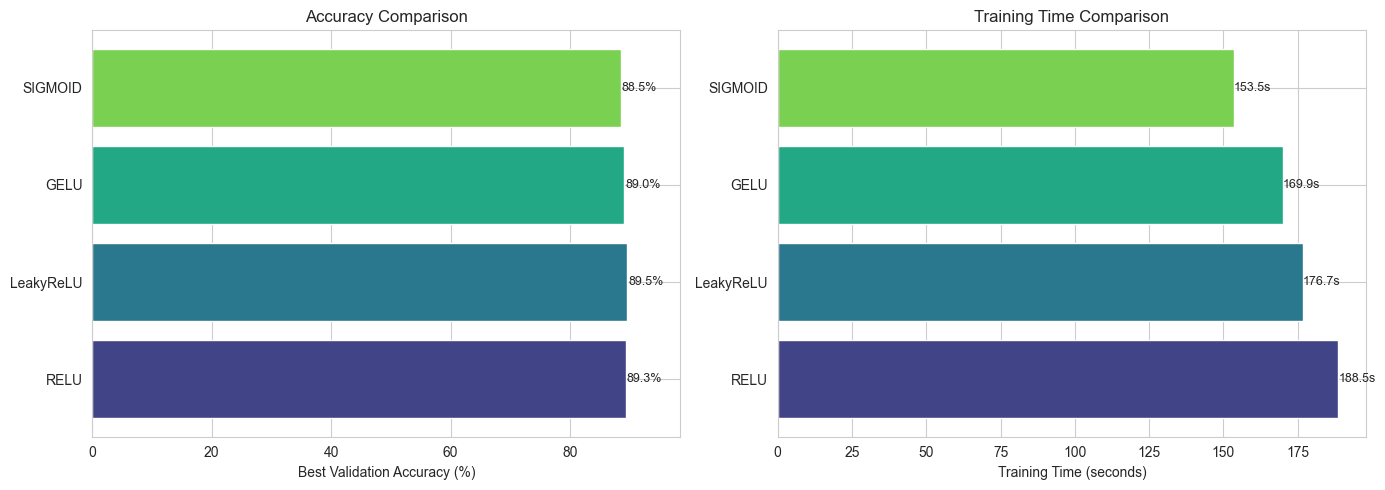

<Figure size 640x480 with 0 Axes>

In [22]:
compare_experiments(activation_results)
plt.savefig('../outputs/activation_comparison.png', dpi=150, bbox_inches='tight')

**Analysis — Activation Functions:**

LeakyReLU performs the best at 89.5%, with ReLU and GELU close behind (89.3% and 89.0%), while Sigmoid is at 88.5%. This is consistent with the vanishing gradient problem, as Sigmoid's saturating gradients make it harder to propagate useful learning signals.

---
## 4. Optimization 


### 4.1 Experiment: Optimizer Comparison

We compare four optimizers:
- **SGD**: Vanilla stochastic gradient descent 
- **SGD + Momentum**: Adds "inertia" to avoid oscillation in ravines
- **Adam**: Adaptive learning rates per-parameter + momentum
- **AdamW**: Adam with proper weight decay 

In [24]:
opt_results = {}

optimizer_configs = {
    'SGD (lr=0.01)': lambda params: optim.SGD(params, lr=0.01),
    'SGD + Momentum': lambda params: optim.SGD(params, lr=0.01, momentum=0.9),
    'Adam (lr=1e-3)': lambda params: optim.Adam(params, lr=1e-3),
    'AdamW (lr=1e-3)': lambda params: optim.AdamW(params, lr=1e-3, weight_decay=1e-2)
}

for name, make_opt in optimizer_configs.items():
    print(f"Training: {name}")
    
    model = FlexibleMLP(num_hidden=2, hidden_dim=128).to(device)
    opt = make_opt(model.parameters())
    history = train_model(model, train_loader, test_loader, opt, criterion, device, epochs=25)
    opt_results[name] = history

Training: SGD (lr=0.01)
  Epoch   1/25 | Train Loss: 1.1687  Acc: 63.9% | Val Loss: 0.7006  Acc: 75.1%
  Epoch   5/25 | Train Loss: 0.4508  Acc: 84.0% | Val Loss: 0.4746  Acc: 82.7%
  Epoch  10/25 | Train Loss: 0.3889  Acc: 86.2% | Val Loss: 0.4247  Acc: 84.6%
  Epoch  15/25 | Train Loss: 0.3551  Acc: 87.3% | Val Loss: 0.4021  Acc: 85.4%
  Epoch  20/25 | Train Loss: 0.3306  Acc: 88.1% | Val Loss: 0.3834  Acc: 86.4%
  Epoch  25/25 | Train Loss: 0.3110  Acc: 88.8% | Val Loss: 0.3647  Acc: 87.0%
  ✓ Best val acc: 86.96% at epoch 25 (183.2s)
Training: SGD + Momentum
  Epoch   1/25 | Train Loss: 0.6073  Acc: 78.4% | Val Loss: 0.4484  Acc: 83.6%
  Epoch   5/25 | Train Loss: 0.3002  Acc: 89.1% | Val Loss: 0.3543  Acc: 87.2%
  Epoch  10/25 | Train Loss: 0.2387  Acc: 91.2% | Val Loss: 0.3586  Acc: 87.5%
  Epoch  15/25 | Train Loss: 0.1978  Acc: 92.7% | Val Loss: 0.3329  Acc: 88.6%
  Epoch  20/25 | Train Loss: 0.1674  Acc: 93.8% | Val Loss: 0.3389  Acc: 88.8%
  Epoch  25/25 | Train Loss: 0.1410 

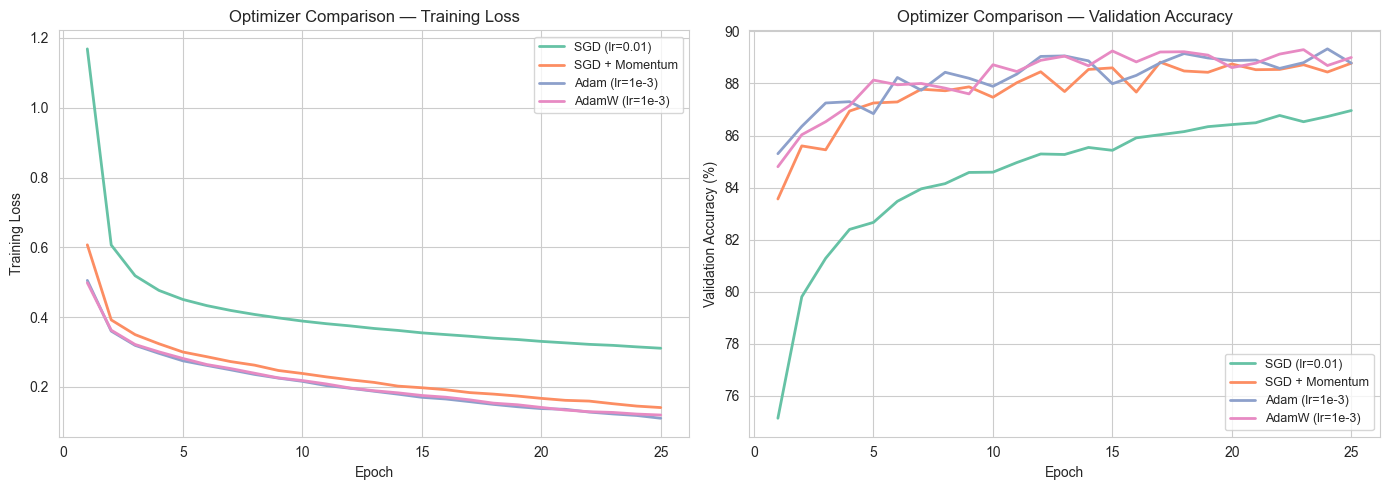

In [25]:
# Overlay training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
colors = sns.color_palette('Set2', len(opt_results))

for (name, hist), color in zip(opt_results.items(), colors):
    epochs = range(1, len(hist['train_loss']) + 1)
    ax1.plot(epochs, hist['train_loss'], label=name, color=color, linewidth=2)
    ax2.plot(epochs, hist['val_acc'], label=name, color=color, linewidth=2)

ax1.set_xlabel('Epoch'); ax1.set_ylabel('Training Loss')
ax1.set_title('Optimizer Comparison — Training Loss'); ax1.legend(fontsize=9)
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Validation Accuracy (%)')
ax2.set_title('Optimizer Comparison — Validation Accuracy'); ax2.legend(fontsize=9)
plt.tight_layout()
plt.savefig('../outputs/optimizer_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

**Analysis — Optimizers:**

Adam and AdamW converge dramatically faster than vanilla SGD - both adaptive optimizers reach ~88% validation accuracy within 5 epochs while SGD (lr=0.01) is still struggling at ~83%, highlighting the power of per-parameter adaptive learning rates. By epoch 25 the gap narrows (SGD catches up to ~89%), but SGD + Momentum, Adam, and AdamW all plateau around 89% much earlier, suggesting that for practical training budgets, adaptive methods are strongly preferred and the additional weight decay in AdamW provides a slight edge in final stability.

### 4.2 Experiment: Learning Rate Schedules

testing different learning rate schedulers

Training: Constant LR
  Epoch   1/20 | Train Loss: 0.5017  Acc: 81.9% | Val Loss: 0.4081  Acc: 85.6%
  Epoch   5/20 | Train Loss: 0.2752  Acc: 89.8% | Val Loss: 0.3544  Acc: 87.5%
  Epoch  10/20 | Train Loss: 0.2101  Acc: 92.1% | Val Loss: 0.3310  Acc: 88.6%
  Epoch  15/20 | Train Loss: 0.1692  Acc: 93.6% | Val Loss: 0.3405  Acc: 89.1%
  Epoch  20/20 | Train Loss: 0.1354  Acc: 94.9% | Val Loss: 0.3877  Acc: 88.8%
  ✓ Best val acc: 89.13% at epoch 15 (177.0s)

Training: StepLR (×0.5 every 10 epochs)
  Epoch   1/20 | Train Loss: 0.5031  Acc: 82.0% | Val Loss: 0.4112  Acc: 85.2%
  Epoch   5/20 | Train Loss: 0.2758  Acc: 89.7% | Val Loss: 0.3365  Acc: 87.8%
  Epoch  10/20 | Train Loss: 0.2144  Acc: 92.0% | Val Loss: 0.3524  Acc: 88.2%
  Epoch  15/20 | Train Loss: 0.1488  Acc: 94.5% | Val Loss: 0.3403  Acc: 89.2%
  Epoch  20/20 | Train Loss: 0.1188  Acc: 95.5% | Val Loss: 0.3795  Acc: 88.9%
  ✓ Best val acc: 89.51% at epoch 19 (171.5s)

Training: Cosine Annealing
  Epoch   1/20 | Train Loss

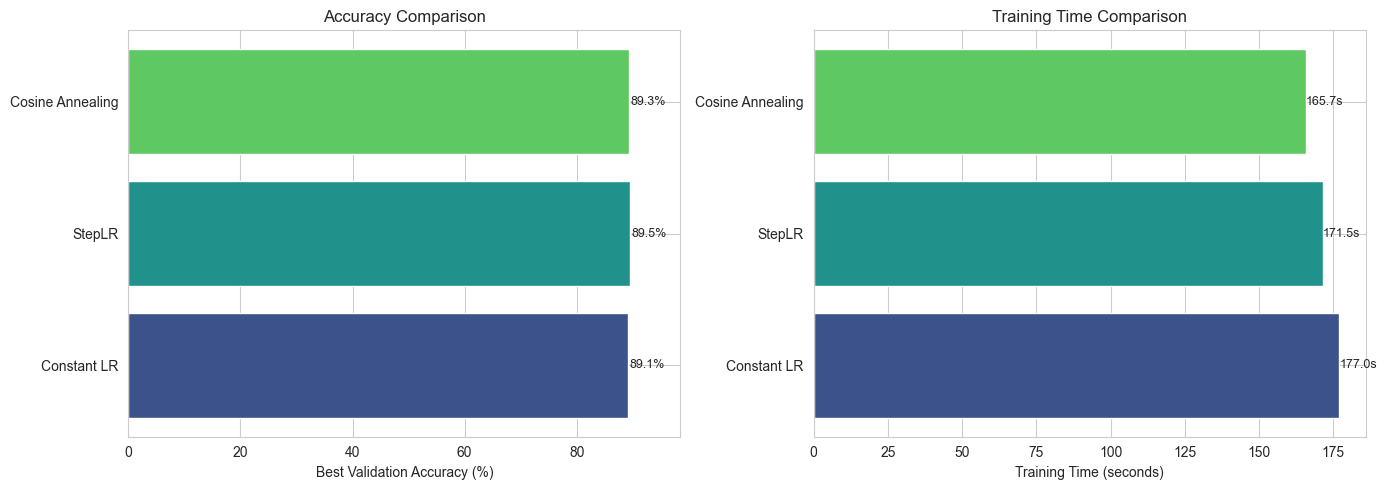

<Figure size 640x480 with 0 Axes>

In [26]:
schedule_results = {}

# Fixed LR
print("Training: Constant LR")
model = FlexibleMLP(num_hidden=2, hidden_dim=128).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
schedule_results['Constant LR'] = train_model(
    model, train_loader, test_loader, opt, criterion, device, epochs=20
)

# StepLR (decay by 0.5 every 10 epochs)
print("\nTraining: StepLR (×0.5 every 10 epochs)")
model = FlexibleMLP(num_hidden=2, hidden_dim=128).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
sched = optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.5)
schedule_results['StepLR'] = train_model(
    model, train_loader, test_loader, opt, criterion, device, epochs=20, scheduler=sched
)

# CosineAnnealingLR
print("\nTraining: Cosine Annealing")
model = FlexibleMLP(num_hidden=2, hidden_dim=128).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=40)
schedule_results['Cosine Annealing'] = train_model(
    model, train_loader, test_loader, opt, criterion, device, epochs=20, scheduler=sched
)

compare_experiments(schedule_results)
plt.savefig('../outputs/schedule_comparison.png', dpi=150, bbox_inches='tight')

### LR Scheduler analysis
StepLR edges out the group at 89.5%, with Cosine Annealing at 89.3% and Constant LR at 89.1% — a tight 0.4% spread suggesting that learning rate scheduling provides a modest but real benefit by allowing the optimizer to make large updates early and fine-tune later. 

### 4.3 Experiment: Regularization

Test three regularization strategies:
- **Dropout**:
- **Weight Decay (L2)**: 
- **Batch Normalization**: 

In [27]:
reg_results = {}

# # No regularization
# print("Training: No regularization")
# model = FlexibleMLP(num_hidden=3, hidden_dim=128).to(device)
# opt = optim.Adam(model.parameters(), lr=1e-3)
# reg_results['No regularization'] = train_model(
#     model, train_loader, test_loader, opt, criterion, device, epochs=20
# )

# Dropout only
print("\nTraining: Dropout 0.3")
model = FlexibleMLP(num_hidden=3, hidden_dim=256, dropout=0.3).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
reg_results['Dropout 0.3'] = train_model(
    model, train_loader, test_loader, opt, criterion, device, epochs=20
)

# Weight decay only
print("\nTraining: Weight Decay 1e-2")
model = FlexibleMLP(num_hidden=3, hidden_dim=256).to(device)
opt = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
reg_results['Weight Decay'] = train_model(
    model, train_loader, test_loader, opt, criterion, device, epochs=20
)

# BatchNorm only
print("\nTraining: BatchNorm")
model = FlexibleMLP(num_hidden=3, hidden_dim=256, use_batchnorm=True).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
reg_results['BatchNorm'] = train_model(
    model, train_loader, test_loader, opt, criterion, device, epochs=20
)

# All combined
print("\nTraining: Dropout + Weight Decay + BatchNorm")
model = FlexibleMLP(num_hidden=3, hidden_dim=256, dropout=0.3, use_batchnorm=True).to(device)
opt = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
reg_results['All Combined'] = train_model(
    model, train_loader, test_loader, opt, criterion, device, epochs=30
)


Training: Dropout 0.3
  Epoch   1/20 | Train Loss: 0.5764  Acc: 79.0% | Val Loss: 0.4315  Acc: 84.4%
  Epoch   5/20 | Train Loss: 0.3421  Acc: 87.5% | Val Loss: 0.3536  Acc: 87.2%
  Epoch  10/20 | Train Loss: 0.2942  Acc: 89.1% | Val Loss: 0.3346  Acc: 88.0%
  Epoch  15/20 | Train Loss: 0.2699  Acc: 90.0% | Val Loss: 0.3173  Acc: 88.5%
  Epoch  20/20 | Train Loss: 0.2504  Acc: 90.7% | Val Loss: 0.3135  Acc: 89.0%
  ✓ Best val acc: 88.95% at epoch 20 (194.0s)

Training: Weight Decay 1e-2
  Epoch   1/20 | Train Loss: 0.4960  Acc: 81.9% | Val Loss: 0.4262  Acc: 84.4%
  Epoch   5/20 | Train Loss: 0.2682  Acc: 89.9% | Val Loss: 0.3382  Acc: 87.3%
  Epoch  10/20 | Train Loss: 0.2026  Acc: 92.3% | Val Loss: 0.3420  Acc: 88.5%
  Epoch  15/20 | Train Loss: 0.1566  Acc: 94.0% | Val Loss: 0.3567  Acc: 89.2%
  Epoch  20/20 | Train Loss: 0.1252  Acc: 95.1% | Val Loss: 0.3867  Acc: 89.2%
  ✓ Best val acc: 89.25% at epoch 19 (182.2s)

Training: BatchNorm
  Epoch   1/20 | Train Loss: 0.4723  Acc: 83.

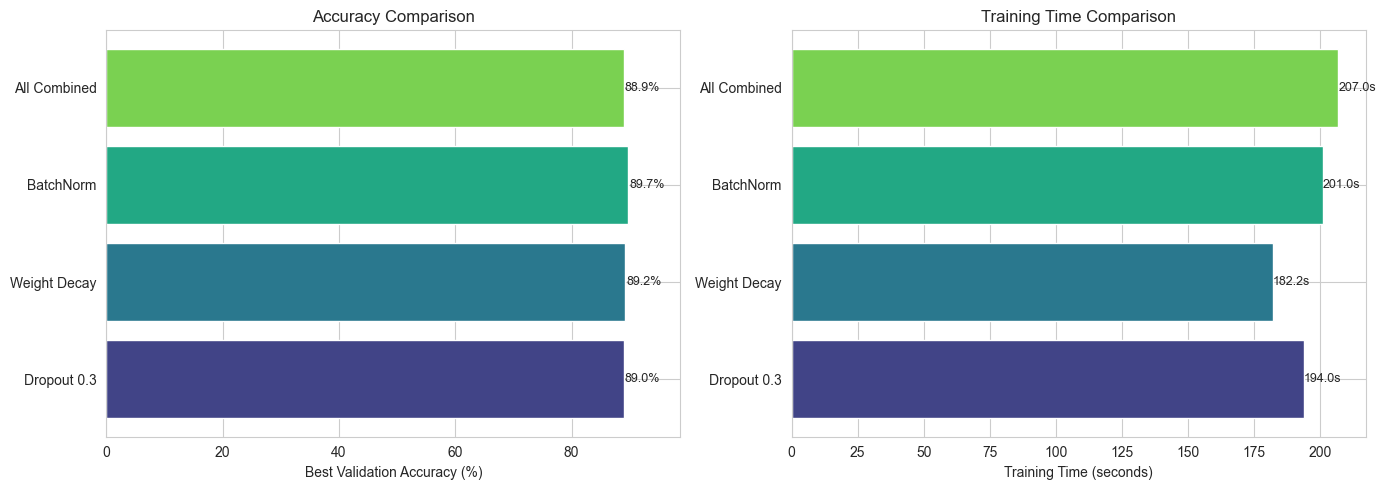

<Figure size 640x480 with 0 Axes>

In [28]:
compare_experiments(reg_results)
plt.savefig('../outputs/regularization_comparison.png', dpi=150, bbox_inches='tight')

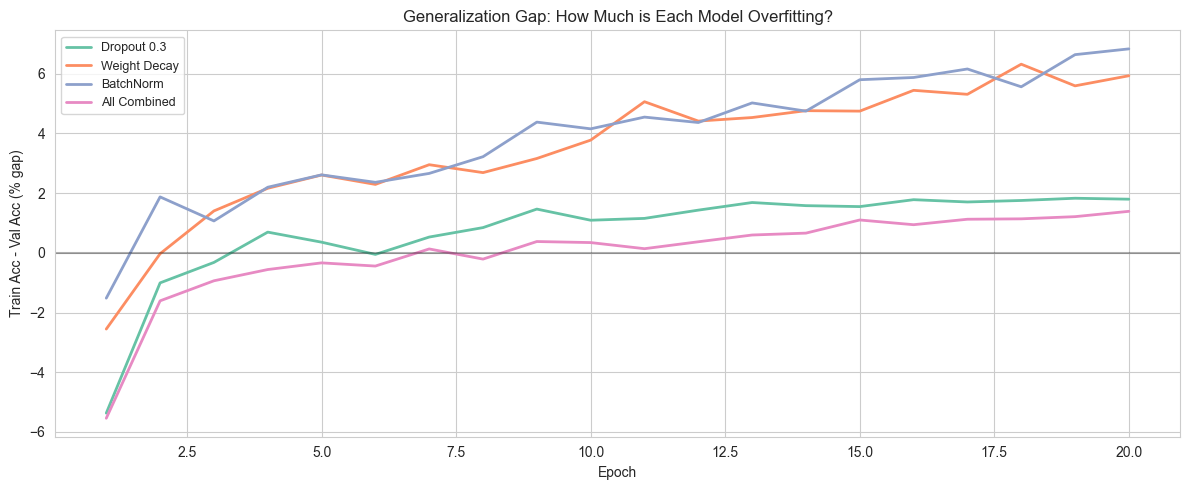

In [29]:
# Show overfitting gap for each regularization method
fig, ax = plt.subplots(figsize=(12, 5))
colors = sns.color_palette('Set2', len(reg_results))

for (name, hist), color in zip(reg_results.items(), colors):
    gap = [t - v for t, v in zip(hist['train_acc'], hist['val_acc'])]
    ax.plot(range(1, len(gap)+1), gap, label=name, color=color, linewidth=2)

ax.set_xlabel('Epoch')
ax.set_ylabel('Train Acc - Val Acc (% gap)')
ax.set_title('Generalization Gap: How Much is Each Model Overfitting?')
ax.legend(fontsize=9)
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/generalization_gap.png', dpi=150, bbox_inches='tight')
plt.show()

**Analysis — Regularization:**

The generalization gap plot tells the real story: "All Combined" (dropout + weight decay + BatchNorm) keeps the train-val gap under ~1% through epoch 20, while BatchNorm and Weight Decay alone balloon to 6-7% — showing that combining regularization techniques is far more effective at controlling overfitting than any single method. Interestingly, BatchNorm achieves the highest raw accuracy (89.7%) but also overfits the most, while "All Combined" trades a small accuracy drop (88.9%) for dramatically better generalization, which is the more important property for real-world deployment.

---
## 5. Conclusions & Reflections

### Key Takeaways

**Architecture:**
- Depth had minimal impact — 1 to 5 hidden layers spanned only 0.5% (89.0%→89.5%), with all configurations overfitting after epoch ~10.
- Width showed similarly diminishing returns, with a 4× parameter increase (64→256) yielding just 0.7% improvement.


**Optimization:**
- Adam and AdamW converged fastest, reaching ~88% within 5 epochs while vanilla SGD lagged at ~83%, though all converged near 89% by epoch 25.
- LR scheduling provided a small but consistent boost (~0.4%), with StepLR slightly outperforming Cosine Annealing and Constant LR.
- Combining dropout, batch normalization, and weight decay was most effective, reducing the generalization gap more than any single technique alone.


### Limitations

- We only explored MLPs — convolutional architectures (CNNs) would better exploit the spatial structure in images and likely outperform even our best MLP significantly.
- We used a fixed train/test split rather than cross-validation, so our results have some variance.
- Hyperparameter search was manual; Bayesian optimization or grid search might find better configurations.


### What I Would Do Next

1. Implement a simple CNN and compare it to the MLP — the spatial structure in images should give a significant boost.
2. Try data augmentation (random flips, rotations) to see how it affects generalization.
3. Implement gradient-based interpretability (saliency maps) to see which pixels drive predictions.